In [1]:
import ipykernel
ipykernel.__version__
import scipy
from scipy import stats

import pandas as pd
import json

# NLTK 
import re
import nltk
import umap.umap_ as UMAP
from nltk import word_tokenize        
nltk.download('wordnet')  
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
import pickle 
from bertopic.representation import MaximalMarginalRelevance
import torch

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/JanayeCheong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### BERTOPIC Overall 

In [63]:
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer, AutoModel
import numpy 

# Path to the pre-trained model
model_path = "microsoft/BiomedVLP-CXR-BERT-specialized"

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
embedding_model = AutoModel.from_pretrained(model_path, trust_remote_code=True)

# Load the structured report database
df_path = 'structured_reports.csv'
database = pd.read_csv(df_path)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [85]:
embeddings = torch.load('../embeddings/intense_pneumonia_embeddings/radiology_embeddings_mean.pt')
type(embeddings)

embeddings.shape

(2759, 768)

In [51]:
reports_df = pd.read_csv('structured_reports.csv')

In [ ]:
from umap import UMAP
from hdbscan import HDBSCAN
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
import torch
import os
# Load the embeddings
database = reports_df 

docs = reports_df['full_text'].tolist()

# UMAP model for dimensionality reduction
umap_model = UMAP(n_neighbors=30, n_components=5, min_dist=0.0, metric='cosine')

# HDBSCAN model for clustering
hdbscan_model = HDBSCAN(min_samples=20, 
                        gen_min_span_tree=True, 
                        prediction_data=True, 
                        min_cluster_size=5, 
                        metric='euclidean', 
                        cluster_selection_method='leaf')

# Create the CountVectorizer instance with the custom LemmaTokenizer
vectorizer_model = CountVectorizer(strip_accents='unicode', 
                                   stop_words='english', 
                                   ngram_range=(1, 3), 
                                   max_df=0.6) # remove general terms 
                                

# Step 1: Initialize custom c-TF-IDF model
ctfidf_model = ClassTfidfTransformer(
    bm25_weighting=False,             # BM25: Beyond a certain point, additional occurrences of a term don’t contribute as much to its weight, introducing a saturation effect. This is controlled by the k1 parameter.
    reduce_frequent_words=True,       # Reduce the impact of overly frequent words (True if needed)
)


# chain model: first extract the most relevant with KeyBERT, then prioritize diversity 
representation_model = [KeyBERTInspired(top_n_words=30, random_state=42), MaximalMarginalRelevance(diversity=0.7)]

# Initialize and fit BERTopic with probability calculation
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    ctfidf_model=ctfidf_model, 
    vectorizer_model=vectorizer_model,
    verbose=True,
    representation_model=representation_model,
    top_n_words=30,
    calculate_probabilities=True,  # Ensure that BERTopic calculates probabilities
)

# Fit the model with documents and embeddings
# probabilities 
topics, probabilities = topic_model.fit_transform(docs, embeddings=embeddings)

# Create the directory if it does not exist
os.makedirs('../../models/NEWBERTopic', exist_ok=True)
os.makedirs('../../models/NEWBERTopic/representations/', exist_ok=True)
os.makedirs('../../models/NEWBERTopic/clusters/', exist_ok=True)

# Save the BERTopic model for later use as a directory 
# Save the ctf-idf matrix  for terms 
topic_model.save("../../models/NEWBERTopic/representations/specter_representation_keybert_mmr", serialization="pytorch", save_ctfidf=True)

# Get HDBSCAN cluster labels and probabilities
hdbscan_labels = topic_model.hdbscan_model.labels_
#The prediction_data=True enables the model to calculate probabilities by predicting how confidently each document fits into a cluster (fits and transforms)
hdbscan_probabilities = topic_model.hdbscan_model.probabilities_ # These probabilities tell you how confidently HDBSCAN assigns a document to its cluster (after fitting embeddings according to hdb model)

# Save HDBSCAN cluster labels and probabilities
torch.save(hdbscan_labels, '../../models/NEWBERTopic/clusters/hdbscan_labels_keybert_mmr.pt')
torch.save(hdbscan_probabilities, '../../models/NEWBERTopic/clusters/hdbscan_probabilities_keybert_mmr.pt')

## Manually save some files to the model directory 
# Save BERTopic probabilities (topic-patent / document-topic matrix) inside the model directory
torch.save(probabilities, '../../models/NEWBERTopic/representations/specter_representation_keybert_mmr/specter_probabilities_keybert_mmr.pt') # the actual document-topic probabilities that delineate association of each document to topic(s)

# Print the topic information after applying custom c-TF-IDF
topic_info = topic_model.get_topic_info()
torch.save(topic_info, '../../models/NEWBERTopic/representations/specter_representation_keybert_mmr/topic_info_keybert_mmr.pt')
topic_info.to_csv('../../models/NEWBERTopic/representations/specter_representation_keybert_mmr/topic_info.csv')
topic_info.to_excel('../../models/NEWBERTopic/representations/specter_representation_keybert_mmr/topic_info.xlsx')

# Save the representation and count vectorizer models to a .pt file
torch.save(representation_model, '../../models/NEWBERTopic/representations/specter_representation_keybert_mmr/representation_model.pt')
torch.save(vectorizer_model, '../../models/NEWBERTopic/representations/specter_representation_keybert_mmr/vectorizer_model.pt')

2024-12-08 13:11:17,631 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-12-08 13:11:24,271 - BERTopic - Dimensionality - Completed ✓
2024-12-08 13:11:24,271 - BERTopic - Cluster - Start clustering the reduced embeddings
2024-12-08 13:11:24,454 - BERTopic - Cluster - Completed ✓
2024-12-08 13:11:24,457 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-12-08 13:11:48,484 - BERTopic - Representation - Completed ✓


In [71]:
probabilities.shape

(2759, 34)

In [77]:
# Start with study_id and subject_id
probability_mapping = pd.DataFrame({
    'study_id': reports_df['study_id'],
    'subject_id': reports_df['subject_id']
})

# Add each probability as its own column
for i in range(probabilities.shape[1]):  # Should be 34 topics
    probability_mapping[f'topic_{i}'] = probabilities[:, i]

# Save the mapping
torch.save(probability_mapping, '../../models/NEWBERTopic/representations/specter_representation_keybert_mmr/probability_mapping.pt')

In [84]:
# Start with study_id and subject_id
probability_mapping = pd.DataFrame({
    'study_id': reports_df['study_id'],
    'subject_id': reports_df['subject_id'],
    'probabilities': list(probabilities)  # Each element will be the probability array for that document
})


probability_mapping.to_csv('probability_mapping_array.csv')

# Save the mapping
torch.save(probability_mapping, '../../models/NEWBERTopic/representations/specter_representation_keybert_mmr/probability_array_mapping.pt')

In [79]:
probability_mapping.head()
probability_mapping.to_csv('probability_mapping.csv')

In [80]:
topic_info

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1824,-1_lower lobe pneumonia_bilateral pleural effu...,"[lower lobe pneumonia, bilateral pleural effus...",[WET READ: [REMOVED] [REMOVED] [REMOVED] 1:54 ...
1,0,117,0_lobe pneumonia notification_frontal lateral ...,"[lobe pneumonia notification, frontal lateral ...",[FINAL REPORT EXAMINATION: CHEST (PORTABLE AP)...
2,1,84,1_effusions pneumothorax_opacity right lung_sm...,"[effusions pneumothorax, opacity right lung, s...",[FINAL REPORT INDICATION: [REMOVED]-year-old m...
3,2,75,2_lobe pneumonia followup_pneumonia pleural ef...,"[lobe pneumonia followup, pneumonia pleural ef...",[FINAL REPORT EXAMINATION: CHEST (PA AND LAT) ...
4,3,58,3_pneumonia findings pa_lungs appear_large eff...,"[pneumonia findings pa, lungs appear, large ef...",[FINAL REPORT CHEST RADIOGRAPH PERFORMED ON [R...
5,4,55,4_pneumonia technique chest_pneumonia pleural ...,"[pneumonia technique chest, pneumonia pleural ...",[WET READ: [REMOVED] [REMOVED] [REMOVED] 11:56...
6,5,46,5_lung volumes bibasilar_relatively low lung_p...,"[lung volumes bibasilar, relatively low lung, ...","[FINAL REPORT EXAM: Chest, frontal and lateral..."
7,6,40,6_consolidation left lung_grossly clear pneumo...,"[consolidation left lung, grossly clear pneumo...",[WET READ: [REMOVED] [REMOVED] [REMOVED] 9:23 ...
8,7,36,7_lingular pneumonia_compatible pneumonia prop...,"[lingular pneumonia, compatible pneumonia prop...",[WET READ: [REMOVED] [REMOVED] [REMOVED] 3:06 ...
9,8,35,8_right atrium pneumothorax_junction evidence ...,"[right atrium pneumothorax, junction evidence ...",[FINAL REPORT INDICATION: Status post central ...


In [81]:
topic_model

In [ ]:
topic_model.visualize_topics()

In [88]:
topic_model.visualize_heatmap()

In [92]:
topic_model.visualize_hierarchy()

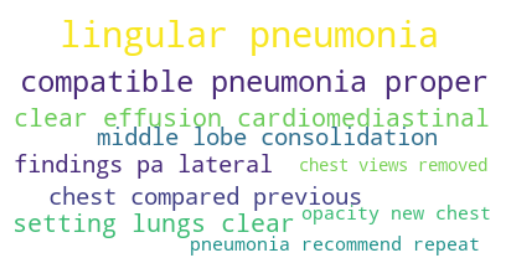

In [104]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=7)

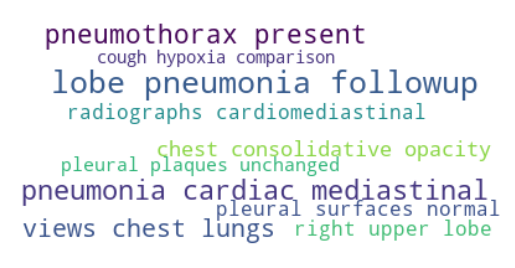

In [109]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

# Show wordcloud
create_wordcloud(topic_model, topic=18)